# CNN for ECG Signal Classification (5 classes)

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

# The Neural Network: CNN

Here I have defined the CNN model with the net class. Here is a breakdown of the architecture:

1. The network starts with a 1 dimensional convolutional layer. The layer takes in the input (which has been reshaped) and produces 64 feature maps with a kernal size of 5. The stride is set to 2 and the maps have a padding of 2. This is activated using the ReLu function. 

2. The output of the first layer is passed to a second 1D convolutional layer, which is also activated with the ReLu function. The output of this convouational layer is then added to the output of an average pooling layer. The average pooling layer is used to reduce the dimensionality of each feature map but retains the most important information. These two layers make up a residual block. 

3. Layer 3 and 4 follow the same principle, but with a difference in padding and applying a batch normalization to the output of the previous layer (now the input).

5. Layer 5 does not use a residual connection, but follows the same principles in the convolutional layer as the previous layer. 

6. The tensor output from layer 5 is flattened to prepare it for the fully connected layers. 

7. The output from the convolutional layers is passed to the first of two fully conected layers. The neurons in the fully connected layer have connections to the activations in the previous layers. This fisrt fully connected layer applies a ReLu activation function. This reduces the dimensionality from 384 to 10. 

8. The final layer is a fully connected layer with no activation function so that the output is a set of logits for each of the 5 classes. This output is not passed to a softmax function explicitly because the training phase uses a cross entropy loss function which automatically combines the softmax function and the negative log likelihood loss function in one. 

In [64]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 5, 2, 2)
        self.conv2 = nn.Conv1d(64, 64, 5, 2, 2)
        self.avg1 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.norm3 = nn. BatchNorm1d(num_features=64)
        self.conv3 = nn.Conv1d(64, 64, 5, 2, 1)
        self.avg2 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.norm4 = nn. BatchNorm1d(num_features=64)
        self.conv4 = nn.Conv1d(64, 64, 5, 2, 1)
        self.avg3 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.norm5 = nn. BatchNorm1d(num_features=64)
        self.conv5 = nn.Conv1d(64, 64, 5, 2, 2)
        self.fc1 = nn.Linear(384, 10)
        self.fc2 = nn.Linear(10, 5)
        
    def forward(self, x):
        x = x.view(x.size(0), 1, x.size(1))

        x1 = nnF.relu(self.conv1(x))

        x2L = nnF.relu(self.conv2(x1))
        x2P = self.avg1(x1)
        x2 = x2L + x2P

        x3L = nnF.relu(self.conv3(self.norm3(x2)))
        x3P = self.avg2(x2)
        x3 = x3L + x3P

        x4L = nnF.relu(self.conv4(self.norm4(x3)))
        x4P = self.avg3(x3)
        x4 = x4L + x4P

        x5 = nnF.relu(self.conv5(self.norm5(x4)))

        xflat = x5.view(x5.size(0),-1)
        xFC1 = nnF.relu(self.fc1(xflat))

        z = self.fc2(xFC1)

        return z

In [ ]:
# Checking the layers in the function to make sure array and tensor sizes are correct
model = Net()
x = torch.rand(2,187) # 2 used to simulate batch normalization
z = model(x)

### Model Checkpointing

Here I define a function to save the state of the model at a particular epoch, which includes the model parameters, optimizer state, and the training results. This allows the model to be evaluated at different stages of training. 

In [49]:
# Defining a checkpoint to save model parameters
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

### Accuracy Calculation

The function below is defined to calculate a model's accuracy, sensitivity, and precision from a confusion matrix. 

In [50]:
# Evaluating model accuracy from confusion matrix
def cal_accuracy(confusion):
    M = confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens = np.zeros(M.shape[0])
    prec = np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP = M[n,n]
        FN = np.sum(M[n,:]) - TP
        FP = np.sum(M[:,n]) - TP
        sens[n] = TP/(TP + FN)
        prec[n] = TP/(TP + FP)       
    return acc, sens, prec

## Training and Testing Functions

The train and test functions handle the training and testing of the model. As previously mentioned, the training function uses the cross entropy loss function. The optimizer's gradient is cleared at the beginning of each step, the model's forward method is run, and the loss is calculated. Then the backwards method is run to calculate the gradients, and the optimizer updates the model parameters based on the gradients.

The testing function evaluates the model's performance by predicting the classes of the input data and comparing those predictions to the actual classes using the confusion matrix defined above.

### Training Function

In [51]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train() # Setting model to training mode
    loss_train = 0
    acc_train = 0 
    sample_count = 0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad() # Clears gradient of each parameter
        Z = model(X) # Forward Pass
        loss = nnF.cross_entropy(Z, Y)
        loss.backward() # Backward Pass
        optimizer.step() # Updates parameters
        loss_train += loss.item()
        Yp = Z.data.max(dim = 1)[1]  # Gets the index of the max               
        acc_train += torch.sum(Yp==Y).item()
        sample_count += X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=sample_count    
    return loss_train, acc_train

### Testing Function

In [52]:
def test(model, device, dataloader):
    model.eval() # Setting model to evaluation mode
    acc_test = 0
    confusion = np.zeros((5, 5))
    with torch.no_grad(): # Telling Pytorch not to calculate gradient
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X) # Forward Pass
            Yp = Z.data.max(dim=1)[1]
            acc_test += torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j] += torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec = cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Creating a custom PyTorch Dataset class

This block defines a custom dataset class which is used to load the data and prepare it to be used by PyTorch. The __get_item__ method returns the input and target variables for a given index. 

In [53]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):        
        x = torch.tensor(self.X[idx], dtype = torch.float32)
        y = torch.tensor(self.Y[idx], dtype = torch.int64)
        return x, y

## Loading and Preprocessing the data

I loaded the data through Google Colab. If you are using your local machine to run the code instead, use the os library to get the exact path of the files using 'os.path.join()'. The dataframe is converted to a numpy array that is workable. The class labels are also checked for imbalance.

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()
X = pd.read_csv('ECG_signals.csv')

uploaded = files.upload()
Y = pd.read_csv('ECG_labels.csv')

In [55]:
# Converting dataframe to numpy array
X = X.values
X.shape

(3841, 187)

In [56]:
Y = Y.values
Y.shape

(3841, 1)

In [57]:
# Flattening Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

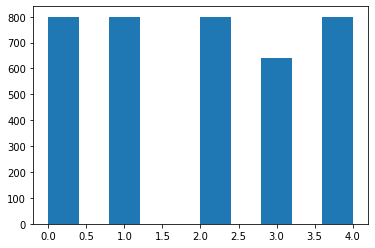

In [58]:
# Checking data for imbalance
plt.hist(Y)

### Visualizing ECG Data

The sampling frequency and interval of the recorded ECG signals is defined to visualize each signal class. There are 5 classes, and 3 examples of each class are plotted per subplot. 

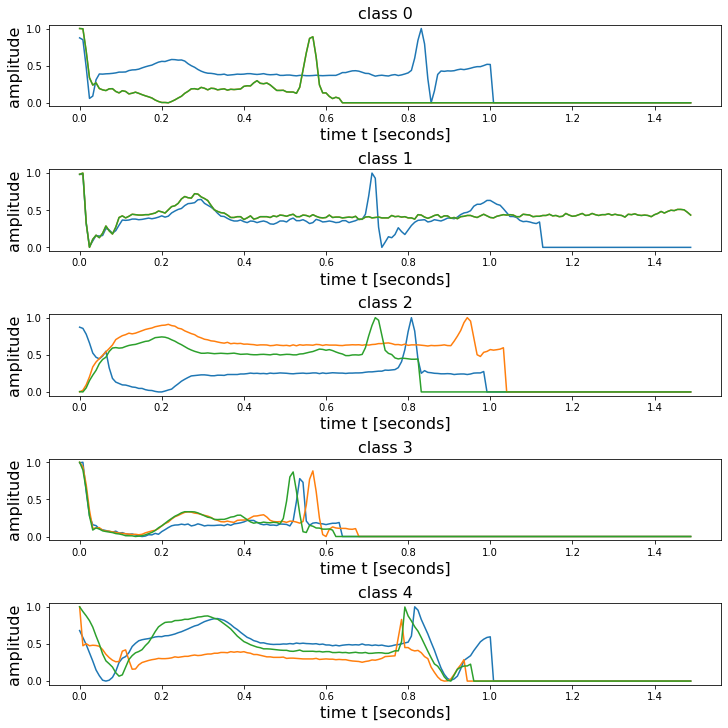

In [59]:
# Preprocessing data
fs = 125  # sampling frequency of ECG
Ts = 1/fs # sampling interval of ECG
N = 187 # the number of timepoints
Duration = N*Ts # duration of a signal
t = np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5, 1, constrained_layout = True, figsize = (10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx = np.random.randint(0, 10)
        ax[c].plot(t, X[Y == c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize = 16)
        ax[c].set_ylabel('amplitude', fontsize = 16)
    ax[c].set_title('class '+ str(c), fontsize = 16)

### Splitting the data into training, validation, and testing sets

In [60]:
# Creating a training/validation/testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 0)

### Dataset and Dataloaders

In [61]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

I used PyTorch Dataloaders to batch the data and shuffle the training data. 

In [62]:
loader_train = torch_dataloader(dataset_train, batch_size = 128, shuffle = True, num_workers = 0)
loader_val = torch_dataloader(dataset_val, batch_size = 128, shuffle = False, num_workers = 0) 
loader_test = torch_dataloader(dataset_test, batch_size = 128, shuffle = False, num_workers = 0) 

## Creating the model and starting the training-validation process

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)
x = dataset_train[0][0]
x = x.view(1,1,187).to(device)
z = model(x)

In [66]:
y_hat = nnF.softmax(z, dim=1)
y_hat

tensor([[0.1974, 0.2243, 0.2635, 0.1333, 0.1815]], grad_fn=<SoftmaxBackward0>)

In [67]:
# Adamax Optimization
optimizer = optim.Adamax(model.parameters(), lr = 0.001, weight_decay = 1e-4)

In [68]:
loss_train_list = []
acc_train_list = []
acc_val_list = []
epoch_save = -1

In [ ]:
# Training and Validation Process
for epoch in range(epoch_save+1, 100):
    #-------- training --------------------------------
    loss_train, acc_train = train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              acc_val_list, other_val)
    save_checkpoint('ECG_CNN_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save = epoch

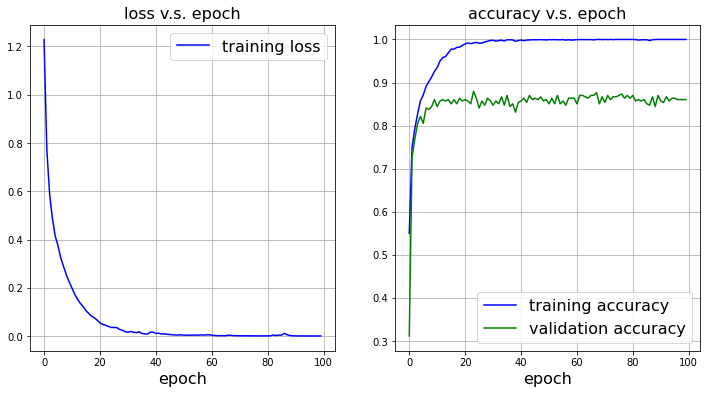

In [70]:
# Plotting the Loss Function and Accuracy for each epoch 
fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].set_title('loss v.s. epoch',fontsize = 16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize = 16)
ax[0].legend(fontsize = 16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize = 16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize = 16)
ax[1].legend(fontsize = 16)
ax[1].grid(True)

In [71]:
# Loading the best model
best_epoch = np.argmax(acc_val_list)
best_epoch

23

## Evaluation Phase

In [72]:
# Selecting best model and running test set
checkpoint = torch.load('ECG_CNN_Pytorch_epoch'+str(best_epoch)+'.pt')
model = Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

In [73]:
# Evaluation of model
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion Matrix\n', confusion)

Accuracy (average) 0.91157347
Sensitivity [0.86363637 0.86363637 0.91780823 0.95081967 0.97076023]
Precision [0.83516484 0.88666666 0.96402878 0.91338581 0.97076023]
Confusion 
 [[152.  16.   1.   4.   3.]
 [ 18. 133.   1.   2.   0.]
 [  5.   0. 134.   5.   2.]
 [  4.   0.   2. 116.   0.]
 [  3.   1.   1.   0. 166.]]
